<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn import metrics


sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

Wayne's definitions: <br> 
<br>
Renovate: [Taken from dictionary.com] <br>
restore (something old, especially a building) to a good state of repair. some synonyms, recondition, reinvigorate, refurbish, restore, redevelop <br>

Fixed:
Renovation does not affect this characteristic in terms of the output values that will be reflected in the given dataset. eg. Basement space is a fixed characteristic,reconstruction of the house is required to change the value of basement space. <br>

Q1: Estimate value of homes using fixed characteristics. <br>
Methodology: <br>
Find out fixed characteristics according to above definition. <br>
EDA <br>
Feature engineering <br>
Modelling + Regularisation/Optimisation <br>
Cross Validation <br>

In [2]:
# Load dataset
house = pd.read_csv('./housing.csv')

In [3]:
# take a look at the dataset remove not residential rows
#house.head()
#house.info()
#house.columns
house['MSZoning'].value_counts()
to_drop = house[house['MSZoning'] == 'C (all)']
to_drop = list(to_drop.index)
house = house.drop(to_drop, axis = 0)
house['MSZoning'].value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

In [4]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 81 columns):
Id               1450 non-null int64
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            89 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-n

In [5]:
house.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [6]:
# Separating fixed characteristics from renovatable ones
all_col = list(house.columns)
fixed = house[['MSSubClass', 
         'MSZoning', 
         'LotFrontage',
         'LotArea',
         'Street',
         'Alley',
         'LotShape',
         'LandContour',
         'Utilities',
         'LotConfig',
         'LandSlope',
         'Neighborhood',
         'Condition1',
         'Condition2',
         'BldgType',
         'HouseStyle',
         'OverallCond',
         'YearBuilt',
         'YearRemodAdd',
         'MasVnrArea',
         'Foundation',
         'BsmtExposure',
         'BsmtFinSF1',
         'BsmtFinSF2',
         'TotalBsmtSF',
         'Electrical',
         '1stFlrSF',
         '2ndFlrSF',
         'GrLivArea',
         'BsmtFullBath',
         'FullBath',
         'BedroomAbvGr',
         'KitchenAbvGr',
         'TotRmsAbvGrd',
         'Fireplaces',
         'GarageType',
         'GarageYrBlt',
         'GarageCars',
         'GarageArea',
         'WoodDeckSF',
         'OpenPorchSF',
         'EnclosedPorch',
         '3SsnPorch',
         'ScreenPorch',
         'PoolArea',
         'MiscFeature',
         'MoSold',
         'YrSold',
         'SaleType',
         'SaleCondition']]
renovate = house.drop(fixed, axis =1)
print(len(fixed), len(renovate.columns))

1450 31


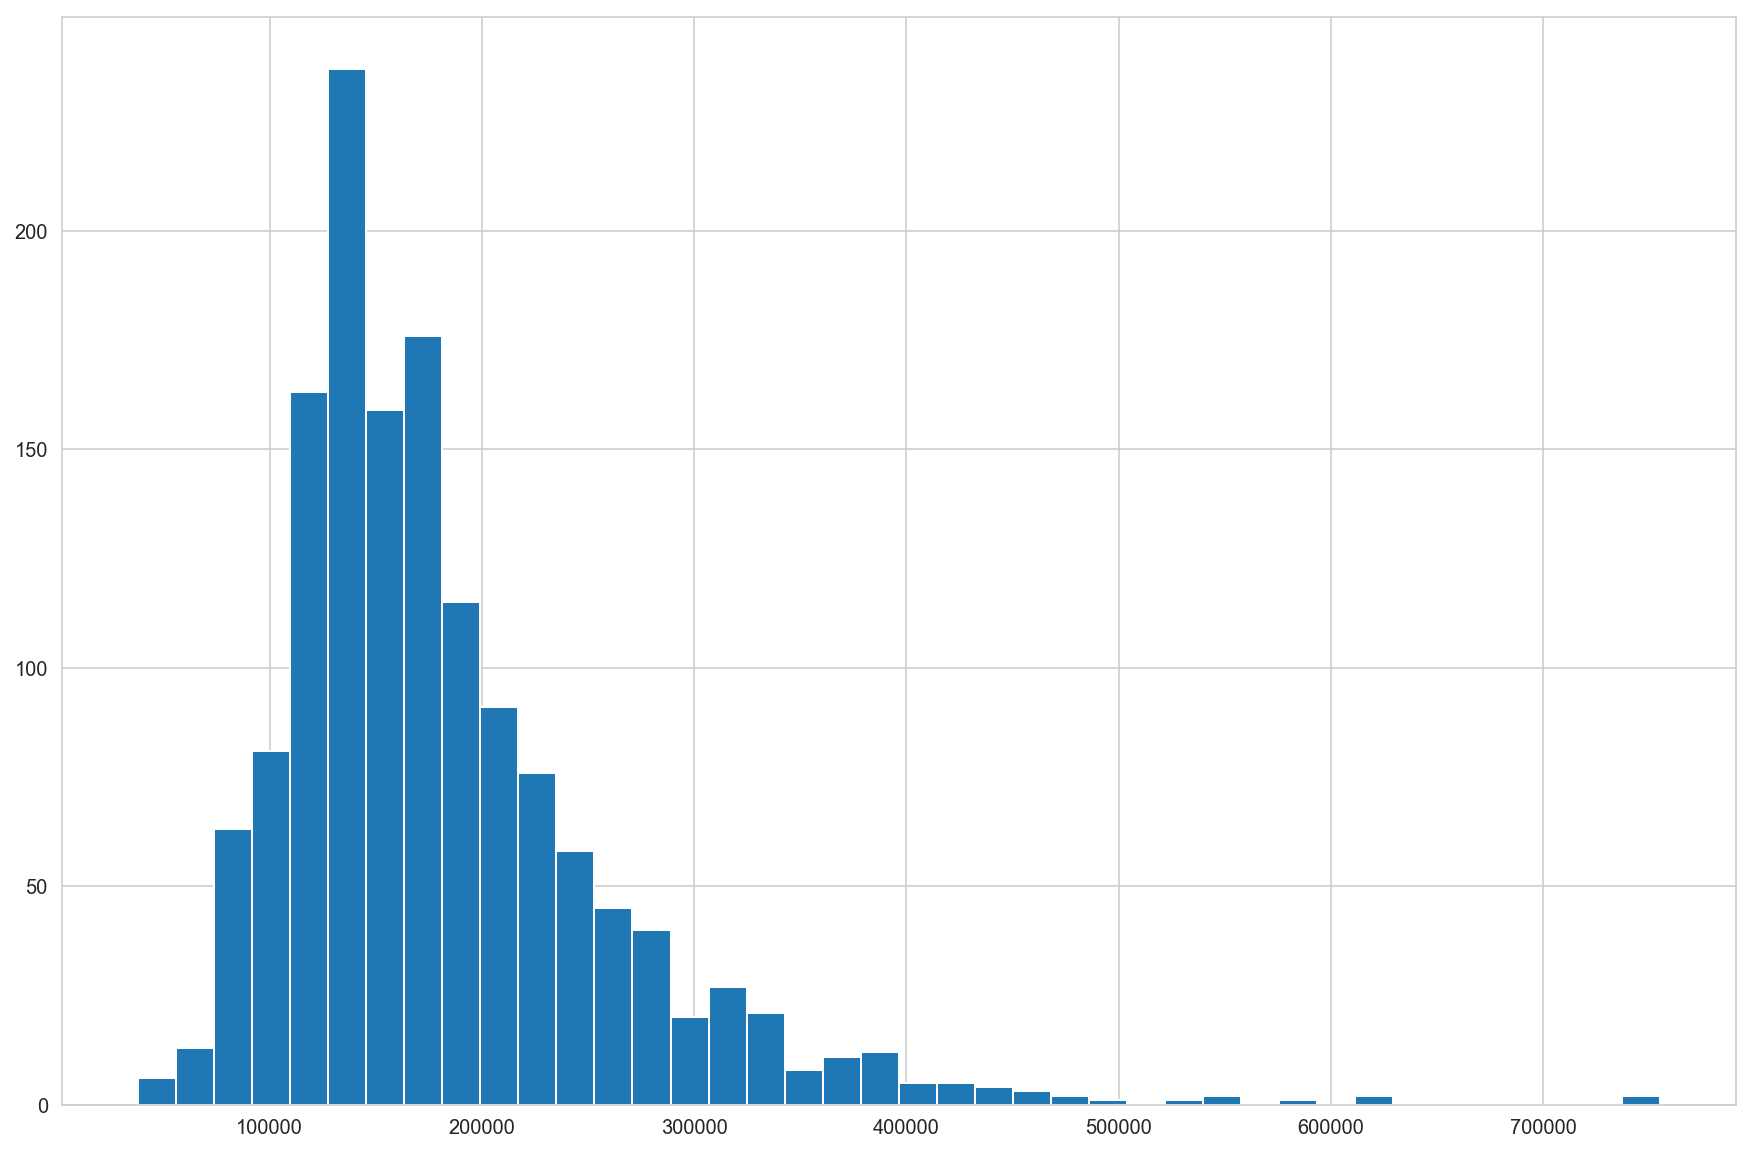

In [7]:
predictor = house[['SalePrice']]
predictor['SalePrice'].describe()
fig = plt.figure(figsize = (15, 10))
ax = plt.gca()
ax.hist(predictor['SalePrice'], bins = 40)
plt.show()

In [8]:
# categorical and continuous variable split for fixed and removing columns that dont make sense or have relation to each other
fixed.columns
fixed_cat = fixed[['MSSubClass', 
               'MSZoning', 
               'Street', 
               'Alley',
               'LotShape', 
               'LandContour', 
               'Utilities', 
               'LotConfig', 
               'LandSlope',
               'Neighborhood', 
               'Condition1',
               'Condition2', 
               'BldgType', 
               'HouseStyle',
               'OverallCond', 
               'YearBuilt', 
               'YearRemodAdd', 
               'Foundation',
               'BsmtExposure', 
               'Electrical',
               'BsmtFullBath', 
               'FullBath',
               'BedroomAbvGr', 
               'KitchenAbvGr', 
               'Fireplaces',
               'GarageType',
               'MiscFeature', 
               'MoSold', 
               'YrSold', 
               'SaleType', 
               'SaleCondition']]
continuous = fixed.drop(fixed_cat, axis =1)
#print(len(categorical.columns), len(continous.columns))
#Dropping TotRmsAbvGrd & GarageYrBlt, due to high correlation (0.8 and above) with 'GrLivArea' & 'YearBuilt'.
fixed_conti = continuous.drop(['TotRmsAbvGrd', 'GarageYrBlt'], axis = 1)

In [9]:
fixed_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 31 columns):
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
Street           1450 non-null object
Alley            89 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
Foundation       1450 non-null object
BsmtExposure     1412 non-null object
Electrical       1449 non-null object
BsmtFullBath     1450 non-null int64
FullBath         1450 non-null int64
BedroomAbvGr     1450 non-null int64
KitchenAbvGr     1450 non-nu

In [10]:
# if 85% of the column and above has the same value or just 2 categories, the column will be binarized to either majority or not
# interior feature of houses should be dummified, not much sense comparing 1 kitchen houses to hses with more kitchens
fixed_cat['Alley'].value_counts() / len(fixed_cat['Alley'])
# Alley will be binarise to 1 = Alley and 0 = no Alley (93%)
fixed_cat.loc[:, 'Alley'] = [0 if x == np.nan else 1 for x in fixed_cat['Alley']]
fixed_cat['Utilities'].value_counts() / len(fixed_cat['Utilities'])
# will drop utilities column because almost 100% is AllPub (99.93%)
fixed_cat['LandContour'].value_counts() / len(fixed_cat['LandContour'])
# LandContour will be binarise to 1 = lvl and 0 = not lvl since 89% is lvl
fixed_cat.loc[:, 'LandContour'] = [1 if x == 'lvl' else 0 for x in fixed_cat['LandContour']]
fixed_cat['Street'].value_counts()
# Since street only consist of pave or grvl, binarise it to 1 = pave & grvl = 0
fixed_cat.loc[:, 'Street'] = [1 if x == 'Pave' else 0 for x in fixed_cat['Street']]
fixed_cat['LandSlope'].value_counts() / len(fixed_cat['LandSlope'])
# LandSlope will be binarised to gtl = 1, not gtl = 0 since gtl makes up the majority and the sev category only has less than 1% (0.89%)
fixed_cat.loc[:, 'LandSlope'] = [1 if x == 'gtl' else 0 for x in fixed_cat['LandSlope']]
fixed_cat['MiscFeature'].isnull().sum() / len(fixed_cat['MiscFeature'])
# MiscFeature will be converted to 1 = theres miscfeature 0 = no miscfeatures since nan makes up 96% of the column and we can still get data
# since the sale price will capture the value of the miscfeatures
fixed_cat.loc[:, 'MiscFeature'] = [0 if x == np.nan else 1 for x in fixed_cat['MiscFeature']]
fixed_cat['SaleCondition'].value_counts() / len(fixed_cat['SaleCondition'])
# SaleCondition will binarise to 1 = normal & not normal = 0
fixed_cat.loc[:, 'SaleCondition'] = [1 if x == 'normal' else 0 for x in fixed_cat['SaleCondition']]
fixed_cat['Condition1'].value_counts() / len(fixed_cat['Condition1'])
# Condition1 will binarise to 1 = normal(86%) & not normal = 0
fixed_cat.loc[:, 'Condition1'] = [1 if x == 'normal' else 0 for x in fixed_cat['Condition1']]
fixed_cat['Condition2'].value_counts() / len(fixed_cat['Condition2'])
# Condition2 will binarise to 1 = normal(98%) & not normal = 0
fixed_cat.loc[:, 'Condition2'] = [1 if x == 'normal' else 0 for x in fixed_cat['Condition2']]
fixed_cat['HouseStyle'].value_counts() / len(fixed_cat['HouseStyle'])
# Housestyle will be dummified
fixed_cat['OverallCond'].value_counts() / len(fixed_cat['OverallCond'])
# OverallCond will be dummified
fixed_cat['Electrical'].value_counts() / len(fixed_cat['Electrical'])
# Electrical will binarise to 1 = SBrkr(91%) & not SBrkr = 0
fixed_cat.loc[:, 'Electrical'] = [1 if x == 'SBrkr' else 0 for x in fixed_cat['Electrical']]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
fixed_conti.info()
fixed_conti.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 17 columns):
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
MasVnrArea       1442 non-null float64
BsmtFinSF1       1450 non-null int64
BsmtFinSF2       1450 non-null int64
TotalBsmtSF      1450 non-null int64
1stFlrSF         1450 non-null int64
2ndFlrSF         1450 non-null int64
GrLivArea        1450 non-null int64
GarageCars       1450 non-null int64
GarageArea       1450 non-null int64
WoodDeckSF       1450 non-null int64
OpenPorchSF      1450 non-null int64
EnclosedPorch    1450 non-null int64
3SsnPorch        1450 non-null int64
ScreenPorch      1450 non-null int64
PoolArea         1450 non-null int64
dtypes: float64(2), int64(15)
memory usage: 203.9 KB


LotFrontage  LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  TotalBsmtSF  \
0         65.0     8450       196.0         706           0          856   
1         80.0     9600         0.0         978           0         1262   
2         68.0    11250       162.0         486           0          920   
3         60.0     9550         0.0         216           0          756   
4         84.0    14260       350.0         655           0         1145   

   1stFlrSF  2ndFlrSF  GrLivArea  GarageCars  GarageArea  WoodDeckSF  \
0       856       854       1710           2         548           0   
1      1262         0       1262           2         460         298   
2       920       866       1786           2         608           0   
3       961       756       1717           3         642           0   
4      1145      1053       2198           3         836         192   

   OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  
0           61              0          0            0         0  
1            0              0          0            0         0  
2           42              0          0            0         0  
3           35            272          0            0         0  
4           84              0          0            0         0

In [12]:
fixed_conti['LotFrontage'].isnull().sum()
# if its a null value, i assume it to not have this feature
fixed_conti.loc[:, 'LotFrontage'] = fixed_conti['LotFrontage'].replace(np.nan, 0)
fixed_conti['MasVnrArea'].isnull().sum()
# if its a null value, i assume it to not have this feature
fixed_conti.loc[:, 'MasVnrArea'] = fixed_conti['MasVnrArea'].replace(np.nan, 0)

In [13]:
def standardise(dataset):
    for col in dataset:
        dataset.loc[:, col] = (dataset[col] - np.mean(dataset[col])) / np.std(dataset[col])
    return dataset

In [14]:
standardised_conti = standardise(fixed_conti)
standardised_conti.head()

LotFrontage   LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  TotalBsmtSF  \
0     0.214936 -0.207202    0.508990    0.571765    -0.28973    -0.463287   
1     0.647114 -0.092303   -0.573359    1.167999    -0.28973     0.461424   
2     0.301372  0.072553    0.321235    0.089517    -0.28973    -0.317520   
3     0.070877 -0.097298   -0.573359   -0.502333    -0.28973    -0.691049   
4     0.762361  0.373291    1.359407    0.459971    -0.28973     0.194943   

   1stFlrSF  2ndFlrSF  GrLivArea  GarageCars  GarageArea  WoodDeckSF  \
0 -0.798869  1.159430   0.366307    0.308312    0.351444   -0.755487   
1  0.251549 -0.795056  -0.487070    0.308312   -0.062451    1.618683   
2 -0.633286  1.186894   0.511076    0.308312    0.633645   -0.755487   
3 -0.527209  0.935145   0.379641    1.650812    0.793559   -0.755487   
4 -0.051158  1.614867   1.295879    1.650812    1.706010    0.774179   

   OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  
0     0.221810      -0.354116  -0.116745    -0.270189 -0.068929  
1    -0.713769      -0.354116  -0.116745    -0.270189 -0.068929  
2    -0.069600      -0.354116  -0.116745    -0.270189 -0.068929  
3    -0.176961       4.118256  -0.116745    -0.270189 -0.068929  
4     0.574569      -0.354116  -0.116745    -0.270189 -0.068929

In [15]:
fixed_cat.loc[:, 'MSSubClass'] = fixed_cat['MSSubClass'].astype(str)

In [16]:
binarised_cat = fixed_cat[['Alley', 'LandContour', 'Street', 'LandSlope', 'MiscFeature', 'SaleCondition', 'Condition1', 'Condition2', 'Electrical']]
binarised_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 9 columns):
Alley            1450 non-null int64
LandContour      1450 non-null int64
Street           1450 non-null int64
LandSlope        1450 non-null int64
MiscFeature      1450 non-null int64
SaleCondition    1450 non-null int64
Condition1       1450 non-null int64
Condition2       1450 non-null int64
Electrical       1450 non-null int64
dtypes: int64(9)
memory usage: 113.3 KB


In [17]:
for_dummying = fixed_cat.drop(binarised_cat, axis = 1)

In [18]:
def to_object(dataset):
    for col in dataset:
        dataset.loc[:, col] = dataset[col].astype(str)
    return dataset

In [19]:
for_dummying = to_object(for_dummying)

In [20]:
dummies = pd.get_dummies(for_dummying)
dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Columns: 318 entries, MSSubClass_120 to SaleType_WD
dtypes: uint8(318)
memory usage: 461.6 KB


In [21]:
print(len(binarised_cat),len(dummies))

1450 1450


In [22]:
bi_dummies_cat = pd.concat([binarised_cat, dummies], axis = 1, sort = False)
new_fixed_cat = pd.concat([standardised_conti, bi_dummies_cat], axis = 1, sort = True)
new_fixed_cat.head()
new_fixed_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Columns: 344 entries, LotFrontage to SaleType_WD
dtypes: float64(17), int64(9), uint8(318)
memory usage: 756.2 KB


In [23]:
# getting the correct data sets to 
y = predictor[['SalePrice']]
X = new_fixed_cat.values
dataset = pd.concat([predictor[['SalePrice']], new_fixed_cat], axis = 1, sort = True)
pre_2010_dataset = dataset[dataset['YrSold_2010'] == 0]
pre_2010_dataset['YrSold_2010'].value_counts()
post_2010_dataset = dataset[dataset['YrSold_2010'] != 0]
post_2010_dataset['YrSold_2010'].value_counts()
# X & y thats pre-2010 yr_built
X = pre_2010_dataset.drop('SalePrice', axis = 1)
y = pre_2010_dataset['SalePrice']
# X_holdup & y_holdup thats post-2010 yr_built
X_holdup = post_2010_dataset.drop('SalePrice', axis = 1)
y_holdup = post_2010_dataset['SalePrice']
print(len(X), len(y), len(X_holdup), len(y_holdup))

1278 1278 172 172


In [24]:
# Multi-Linear Reression model (No ridge or lasso yet) to see how well the model is if we just throw everything in
#print(len(X_train), len(y_train), len(X_test), len(y_test))
lr = LinearRegression()
model = lr.fit(X, y)
results_train = model.score(X_holdup, y_holdup)
print(results_train)
# 10-fold xval_score on train data
xval_score_train = cross_val_score(lr, X, y, cv = 10)
print(xval_score_train, np.mean(xval_score_train), np.std(xval_score_train))
# results using everything is not gd 
# severe overfitting - large std deviations and low score of 0.4 when using pre2010 fitted model while doing gd on itself.

-1.2782642986671014e+19
[-1.58223803e+19  8.33128445e-01 -1.36622204e+20 -2.15933947e+15
 -3.69651175e+19 -1.65856783e+20 -7.30165089e+18  8.02346898e-01
 -1.74372014e+15 -5.56267057e+14] -3.6257259497477976e+19 5.8905256283547025e+19


In [25]:
# create ridge and lasso regularisation functions to find best alpha
def ridge_alpha(predictor_train, target_train, alpha):
    ridge_value = []
    for number in alpha:
        ridgereg = Ridge(alpha=number, normalize=True)
        score_train = cross_val_score(ridgereg, predictor_train, target_train, cv = 10)
        ridge_value.append([number, np.mean(score_train), np.std(score_train)])
    ridge_value.sort(key=lambda x: x[1])
    return ridge_value[-1]

In [26]:
def lasso_alpha(predictor_train, target_train, alpha):
    lasso_value = []
    for number in alpha:
        lassoreg = Lasso(alpha=number, max_iter = 10000, normalize=True)
        score_train = cross_val_score(lassoreg, predictor_train, target_train, cv = 10)
        lasso_value.append([number, np.mean(score_train), np.std(score_train)])
    lasso_value.sort(key=lambda x: x[1])
    return lasso_value[-1]

In [27]:
# using ridge:
alpha = np.arange(0.5, 0.7, 0.001)
best_alpha_r = ridge_alpha(X, y, alpha)
best_alpha_r

[0.6090000000000001, 0.796687659553964, 0.09605870253361254]

In [28]:
# Using best alpha for ridge model
ridge = Ridge(alpha = 0.609, normalize = True)
ridge_model = ridge.fit(X, y)
r_test_score = ridge_model.score(X_holdup, y_holdup)
r_test_score

0.8337818933417888

In [ ]:
# using lasso:
alpha = np.arange(30, 35, 0.01)
best_alpha_l = lasso_alpha(X, y, alpha)
best_alpha_l

In [30]:
lasso = Lasso(alpha = 31.83, normalize = True)
lasso_model = lasso.fit(X, y)
l_test_score = lasso_model.score(X_holdup, y_holdup)
l_test_score

0.855411200098558

Lasso scores 0.855 with mean x val score of 0.803 and std of 0.106 while Ridge scores 0.834 with mean xval at 0.797 and std of 0.0961. Hard to tell which one is better.<br>
<br>
Next steps will be: <br>
1. try using lasso to eliminate some values to create a new set of predictor matrix and fit it into a ridge model <br>
2. use RFECV to find the best features for new pred matrix <br>
3. use KBestSlection <br>

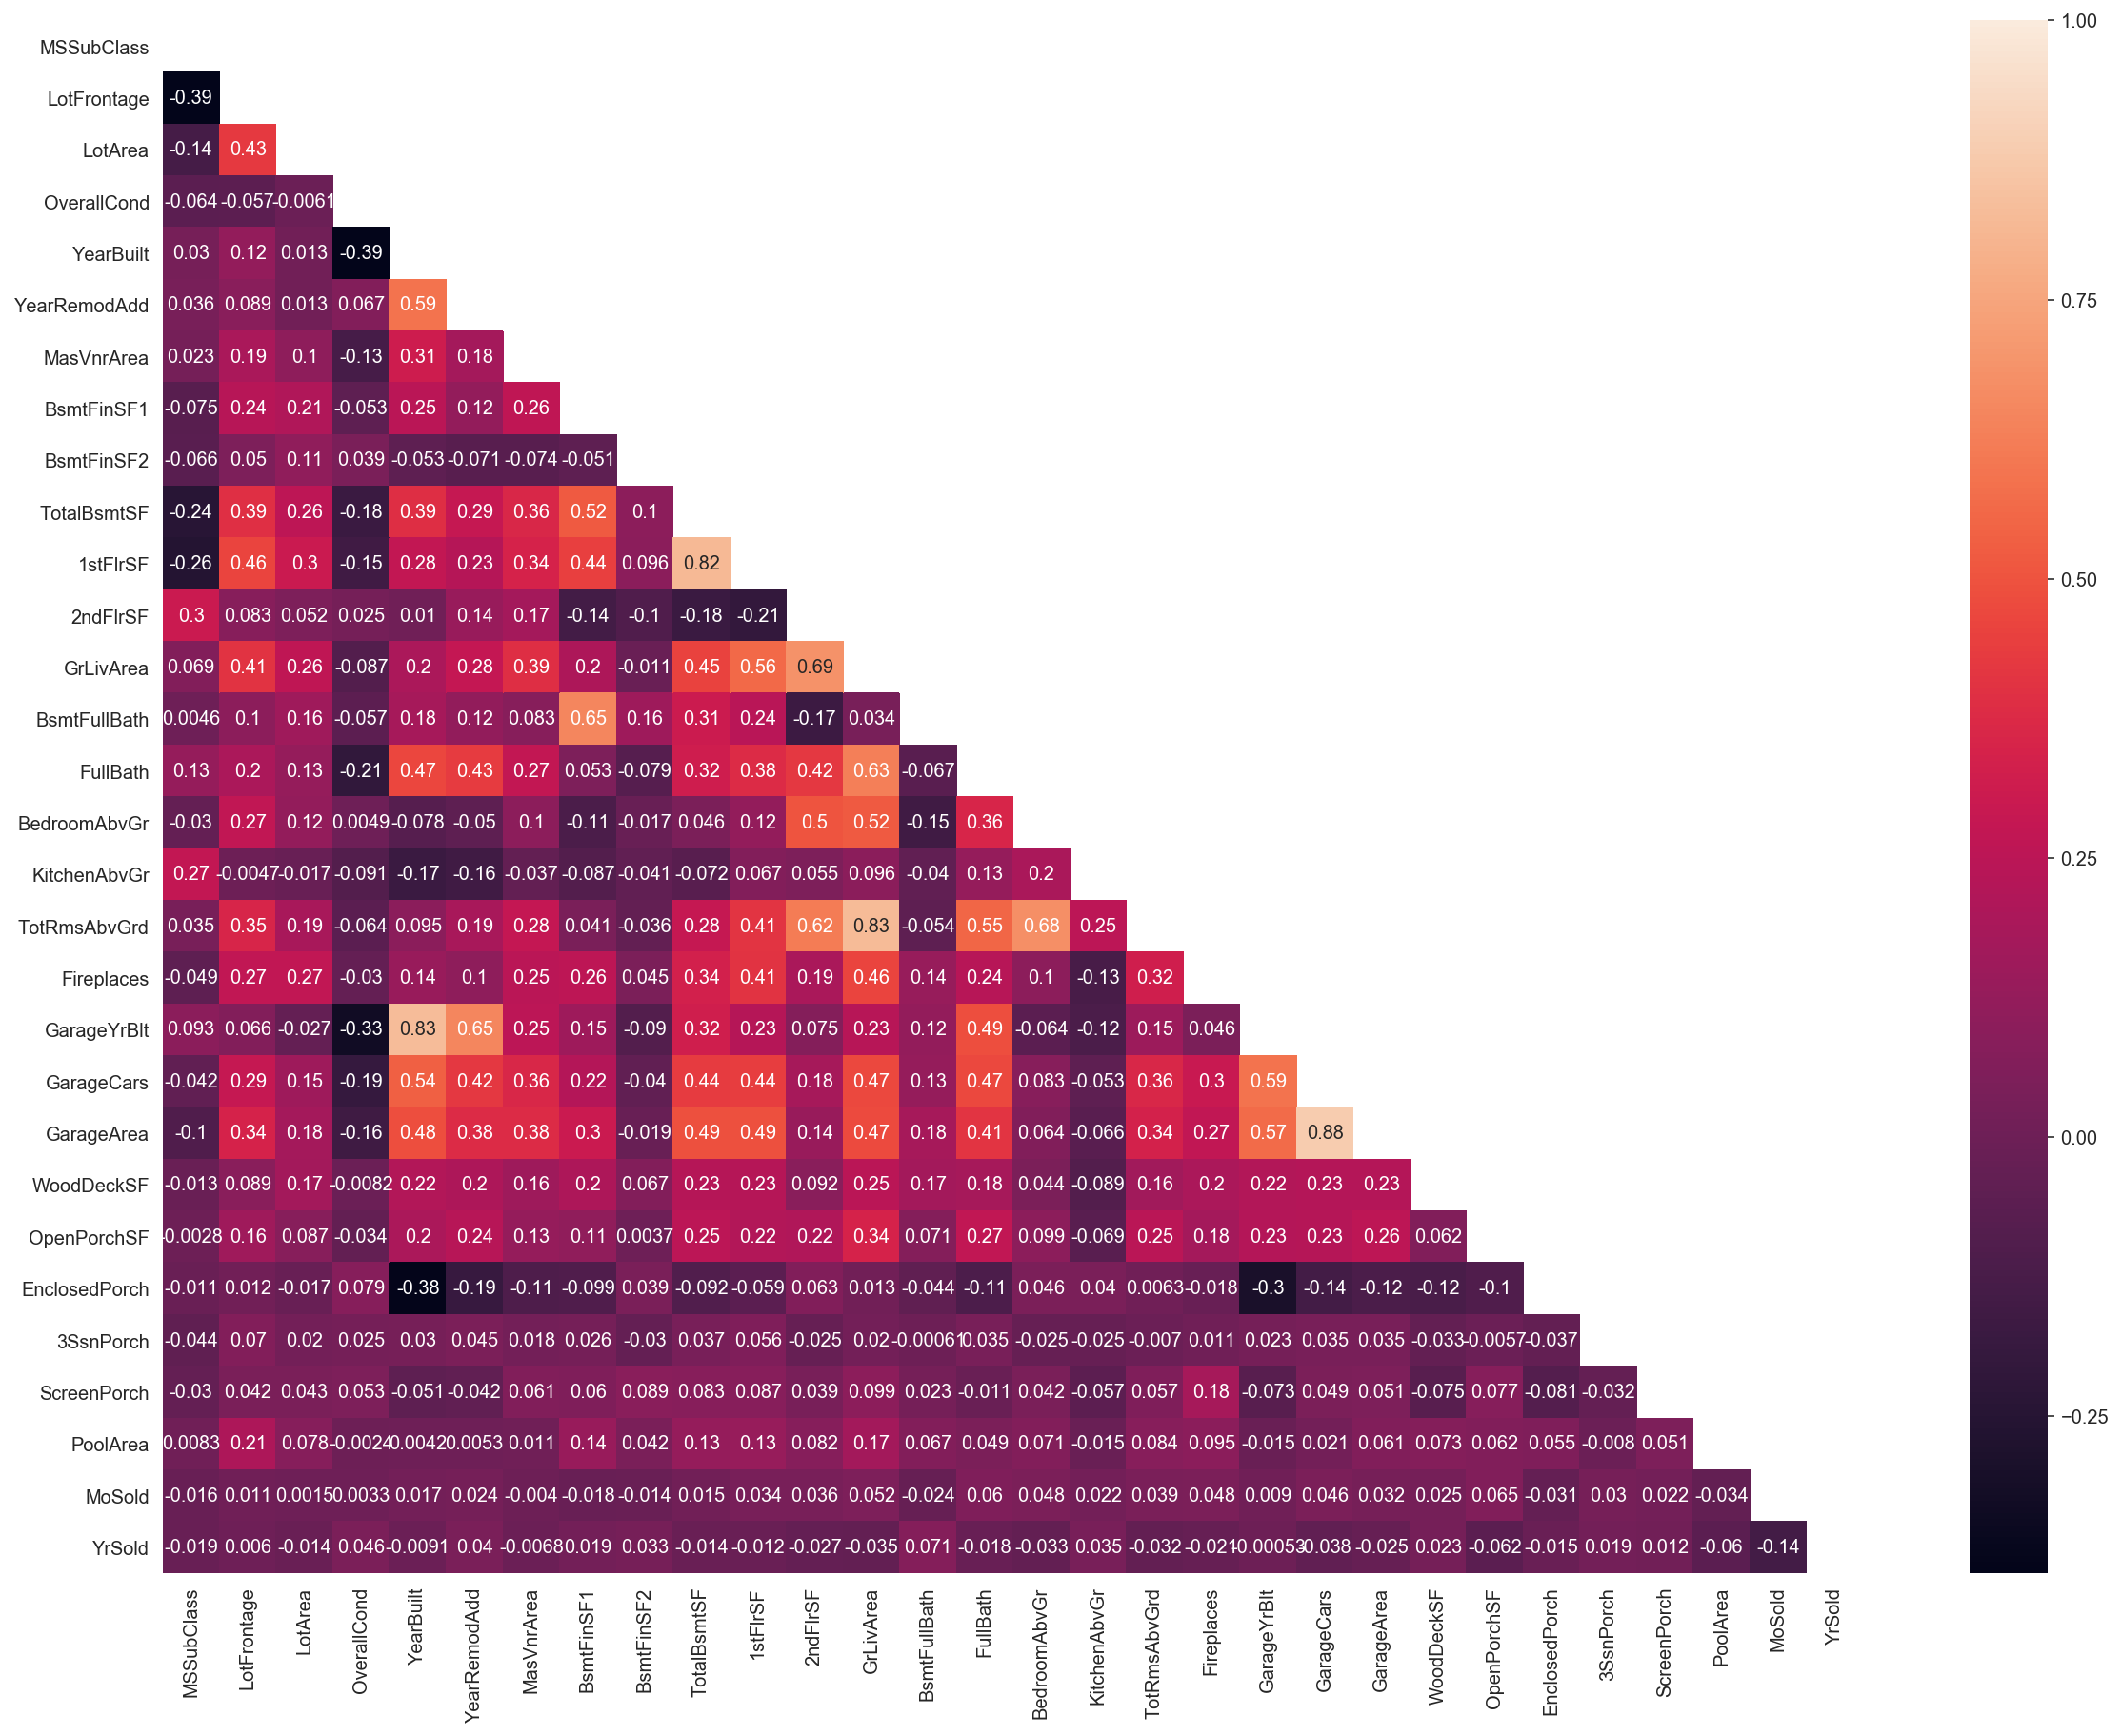

In [31]:
# Take a look at the correlation between fixed variables
# from heatmap, some features with high correlation can be dropped to prevent multicollinearity
# drop columns that I deem should not be useful
fig = plt.figure(figsize = (20,15))
mask = np.zeros_like(fixed.corr(), dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(fixed.corr(), mask = mask, annot = True)
plt.show()
to_drop = ['GarageYrBlt', 
           'GarageCars', 
           'YearBuilt', 
           'MoSold', 
           'YrSold', 
           'Street', 
           'Alley', 
           'LandSlope', 
           'LandContour', 
           'Electrical', 
           'YearRemodAdd',
           'MasVnrArea',
           'LotFrontage',
           'LotShape', 
           'LotConfig',
           'MSSubClass',
           'BldgType', 
           'HouseStyle',
           'BsmtFinSF1',
           'BsmtFinSF2',
           'TotRmsAbvGrd',
           'GrLivArea']

In [32]:
new_fixed = fixed.drop(to_drop, axis = 1)

In [33]:
# We can combine the 1stFlrSF, 2ndFltSF, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch,3SsnPorch & ScreenPorch to get the overall space of a house
new_fixed['overallhsesf'] = new_fixed['1stFlrSF'] \
                          + new_fixed['2ndFlrSF'] \
                          + new_fixed['GarageArea'] \
                          + new_fixed['WoodDeckSF'] \
                          + new_fixed['OpenPorchSF'] \
                          + new_fixed['EnclosedPorch'] \
                          + new_fixed['3SsnPorch'] \
                          + new_fixed['ScreenPorch']
new_fixed['overallhsesf']
new_fixed = new_fixed.drop(['Utilities', 
                            '1stFlrSF', 
                            '2ndFlrSF', 
                            'GarageArea', 
                            'WoodDeckSF', 
                            'OpenPorchSF', 
                            'EnclosedPorch', 
                            '3SsnPorch', 
                            'ScreenPorch'], axis = 1)
len(new_fixed.columns)

20

In [34]:
categorical = fixed[['MSZoning',
               'Neighborhood', 
               'Condition1',
               'Condition2',
               'OverallCond', 
               'Foundation',
               'BsmtExposure', 
               'BsmtFullBath', 
               'FullBath',
               'BedroomAbvGr', 
               'KitchenAbvGr', 
               'Fireplaces',
               'GarageType',
               'MiscFeature',  
               'SaleType', 
               'SaleCondition']]
continuous = new_fixed.drop(categorical, axis = 1)

In [44]:
for_bi = categorical[['MiscFeature', 'SaleCondition', 'Condition1', 'Condition2']]
for_bi.loc[:, 'MiscFeature'] = [0 if x == np.nan else 1 for x in for_bi['MiscFeature']]
for_bi.loc[:, 'SaleCondition'] = [1 if x == 'normal' else 0 for x in for_bi['SaleCondition']]
for_bi.loc[:, 'Condition1'] = [1 if x == 'normal' else 0 for x in for_bi['Condition1']]
for_bi.loc[:, 'Condition2'] = [1 if x == 'normal' else 0 for x in for_bi['Condition2']]
for_dummy = categorical.drop(for_bi, axis = 1)
dummies = pd.get_dummies(for_dummy)
bi_dummy = pd.concat([for_bi, dummies], axis = 1, sort = True)
bi_dummy.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


MiscFeature  SaleCondition  Condition1  Condition2  OverallCond  \
0            1              0           0           0            5   
1            1              0           0           0            8   
2            1              0           0           0            5   
3            1              0           0           0            5   
4            1              0           0           0            5   

   BsmtFullBath  FullBath  BedroomAbvGr  KitchenAbvGr  Fireplaces  \
0             1         2             3             1           0   
1             0         2             3             1           1   
2             1         2             3             1           1   
3             1         1             3             1           1   
4             1         2             4             1           1   

      ...       GarageType_Detchd  SaleType_COD  SaleType_CWD  SaleType_Con  \
0     ...                       0             0             0             0   
1     ...                       0             0             0             0   
2     ...                       0             0             0             0   
3     ...                       1             0             0             0   
4     ...                       0             0             0             0   

   SaleType_ConLD  SaleType_ConLI  SaleType_ConLw  SaleType_New  SaleType_Oth  \
0               0               0               0             0             0   
1               0               0               0             0             0   
2               0               0               0             0             0   
3               0               0               0             0             0   
4               0               0               0             0             0   

   SaleType_WD  
0            1  
1            1  
2            1  
3            1  
4            1  

[5 rows x 64 columns]

In [45]:
# datasets that went thru first round of feature engineering
std_conti = standardise(continuous)
std_conti.head()
new_fixed_features = pd.concat([std_conti, bi_dummy], axis = 1, sort = True)
pre_2010 = new_fixed_features[dataset['YrSold_2010'] == 0]
post_2010 = new_fixed_features[dataset['YrSold_2010'] != 0]
new_X = pre_2010
new_X_holdup = post_2010
new_y = y
new_y_holdup = y_holdup

In [46]:
new_fixed_features.isnull().sum()

LotArea                 0
TotalBsmtSF             0
PoolArea                0
overallhsesf            0
MiscFeature             0
SaleCondition           0
Condition1              0
Condition2              0
OverallCond             0
BsmtFullBath            0
FullBath                0
BedroomAbvGr            0
KitchenAbvGr            0
Fireplaces              0
MSZoning_FV             0
MSZoning_RH             0
MSZoning_RL             0
MSZoning_RM             0
Neighborhood_Blmngtn    0
Neighborhood_Blueste    0
Neighborhood_BrDale     0
Neighborhood_BrkSide    0
Neighborhood_ClearCr    0
Neighborhood_CollgCr    0
Neighborhood_Crawfor    0
Neighborhood_Edwards    0
Neighborhood_Gilbert    0
Neighborhood_IDOTRR     0
Neighborhood_MeadowV    0
Neighborhood_Mitchel    0
                       ..
Neighborhood_SawyerW    0
Neighborhood_Somerst    0
Neighborhood_StoneBr    0
Neighborhood_Timber     0
Neighborhood_Veenker    0
Foundation_BrkTil       0
Foundation_CBlock       0
Foundation_P

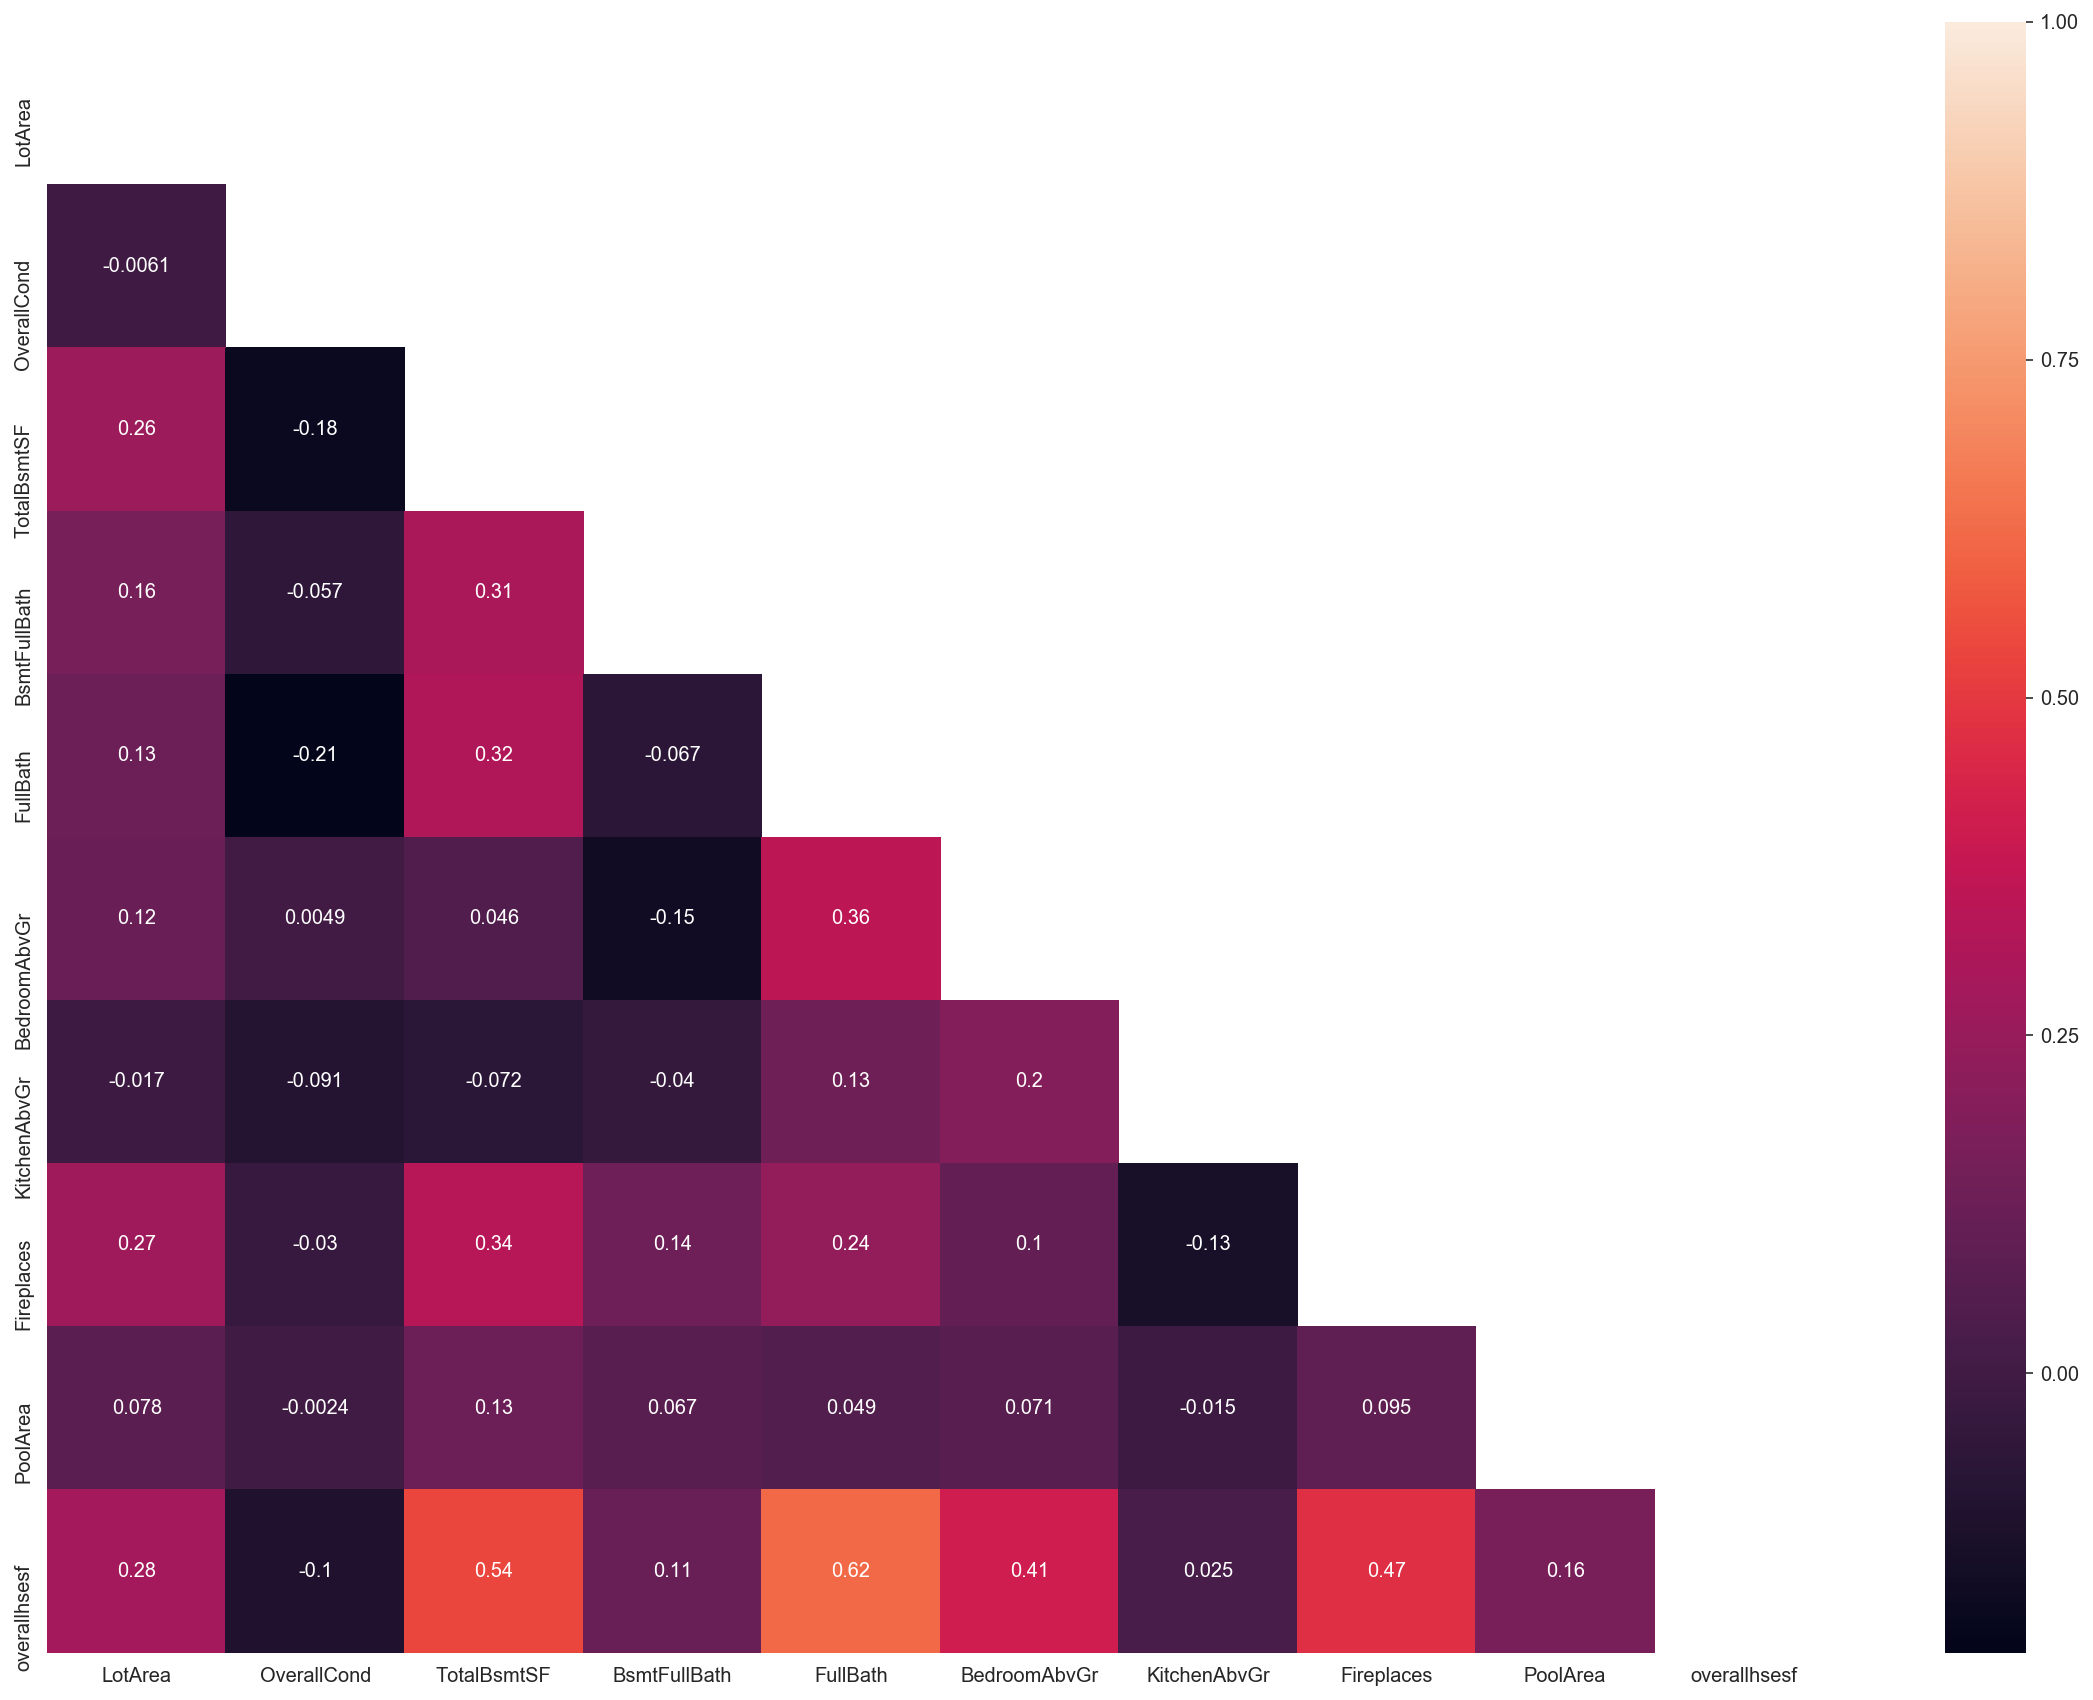

In [47]:
fig = plt.figure(figsize = (20,15))
mask = np.zeros_like(new_fixed.corr(), dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(new_fixed.corr(), mask = mask, annot = True)
plt.show()

In [48]:
from sklearn.feature_selection import RFECV, SelectKBest, f_classif

In [49]:
# Linear model with new predictors, as usual still not good, severely overfitted.
lr = LinearRegression()
train_score = cross_val_score(lr, new_X, new_y, cv = 10)
lr_model = lr.fit(new_X, new_y)
test_score = lr_model.score(new_X_holdup, new_y_holdup)
print(test_score, train_score, np.mean(train_score), np.std(train_score))

0.8241966759539873 [ 8.67040417e-01  8.46628831e-01 -2.96615518e+18  7.81022830e-01
  8.08715750e-01  8.40580498e-01  8.41100620e-01  8.10940748e-01
  5.45312423e-01  8.50708662e-01] -2.9661551809556115e+17 8.898465542866834e+17


In [41]:
# ridge model with new predictors
alpha = np.arange(0.001, 0.1, 0.001)
r_alpha = ridge_alpha(new_X, new_y, alpha)
r_alpha

[0.075, 0.8073953338639945, 0.08260674205162985]

In [50]:
ridge = Ridge(alpha = 0.075, normalize = True)
train_score = cross_val_score(ridge, new_X, new_y, cv = 10)
ridge_model = ridge.fit(new_X, new_y)
test_score = ridge_model.score(new_X_holdup, new_y_holdup)
print(test_score, train_score, np.mean(train_score), np.std(train_score))

0.8242327738891273 [0.86589066 0.83325602 0.85313314 0.78758112 0.80391694 0.84326023
 0.85256501 0.81288573 0.57000668 0.85145782] 0.8073953338639945 0.08260674205162992


In [43]:
alpha = np.arange(14, 20, 0.01)
l_alpha = lasso_alpha(new_X, new_y, alpha)
l_alpha

KeyboardInterrupt: 

In [51]:
lasso = Lasso(alpha = 15.089, normalize = True)
train_score = cross_val_score(lasso, new_X, new_y, cv = 10)
lasso_model = lasso.fit(new_X, new_y)
test_score = lasso_model.score(new_X_holdup, new_y_holdup)
print(test_score, train_score, np.mean(train_score), np.std(train_score))

0.8278240564956084 [0.87162338 0.8456917  0.85204655 0.78250688 0.81066928 0.84149725
 0.85328129 0.80786587 0.55701132 0.85553735] 0.8077730865527665 0.08746016315648626


Both Ridge and Lasso gives almost the same values. Apply RFECV.

In [53]:
# Using RFECV with Ridge as estimator to try n eiminate features that dun help in our model
estimator = ridge
selector = RFECV(estimator, step=1, cv=10)
selector = selector.fit(new_X, new_y)
print(selector.score(new_X_holdup, new_y_holdup))
rrfecv = pd.DataFrame(new_X.columns, columns = ['feature'])
rrfecv['ranking'] = selector.ranking_
rrfecv['false = drop'] = selector.support_
drop = rrfecv[rrfecv['false = drop'] == False].index
rrfecv = rrfecv.drop(drop, axis = 0)
len(rrfecv)

0.8243767137319343


55

In [54]:
# Using RFECV with Lasso as estimator
estimator = lasso
selector = RFECV(estimator, step=1, cv=10)
selector = selector.fit(new_X, new_y)
print(selector.score(new_X_holdup, new_y_holdup))
lrfecv = pd.DataFrame(new_X.columns, columns = ['feature'])
lrfecv['ranking'] = selector.ranking_
lrfecv['false = drop'] = selector.support_
drop = lrfecv[lrfecv['false = drop'] == False].index
lrfecv = lrfecv.drop(drop, axis = 0)
len(lrfecv)

0.8282675916694233


39

I will go for lasso model + RFECV feature selection soley due to the fact lasso model has higher score <br>
Features that gave me the model with highest score (linear + lasso + RFECV) are:
1. TotalBsmtSF 
2. overallhsesf 
3. BsmtFullBath 
4. FullBath 
5. KitchenAbvGr 
6. Fireplaces 
7. Neighborhood 
8. Foundation 
9. BsmtExposure 
10. GarageType
11. SalesType
12. MSZoning
13. Overallcond<br>
<br>
These features from a company point of view also seem to make most sense that will play a more significant role than other features <br>
Hence I will just end the feature engineering and selection and settle for this model to predict house prices based on fixed characteristics.

## <img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

Some thoughts: <br>
To evaluate the effect in dollars of the renovate-able features, the only way i can think of is utilizing the (y - y_pred) of our fixed  characteristics model from question 1 and compare (y - y_pred) of the new model with renovatable features added in. <br>
<br>
I am not sure how to explain using coefficients to determine whether to buy a property? <br>
To determine whether they should buy a property or not seems to be a yes no question which falls under classification? Maybe logistic model? <br>
<br>
One way I can think of prior to modelling is that the residuals can give us a variance in dollar value, if (fixed+renovatable) model gives us a smaller variance than just the fixed model, the difference in variance will be the dollar value of the renovatable features. <br>
Does that make a good argument?<br>

In [55]:
# drop the removatable features not related to the 11 fixed features chosen for 1st model and not related not quality or condition.
# OverallQual seems to encompass some quality features, those quality features will be dropped
#PoolQC will be dropped since most are null values
reno = renovate.drop(['Id',
                      'ExterQual',
                      'Exterior1st',
                      'Exterior2nd',
                      'RoofStyle', 
                      'RoofMatl', 
                      'MasVnrType',
                      'BsmtQual',
                      'BsmtUnfSF',
                      'LowQualFinSF',
                      'Functional',
                      'BsmtFinType1', 
                      'BsmtFinType2',
                      'Heating', 
                      'FireplaceQu',
                      'BsmtHalfBath',
                      'HalfBath',
                      'GarageFinish',
                      'Fence',
                      'MiscVal',
                      'SalePrice',
                      'PoolQC'], axis = 1)

In [56]:
# Clean up the null values
# null values will be replaced by the object 'na' reason being if its null, most prob the house do not have that feature
# overallquad will be kept as a continuous variable column
reno.isnull().sum()

OverallQual     0
ExterCond       0
BsmtCond       37
HeatingQC       0
CentralAir      0
KitchenQual     0
GarageQual     79
GarageCond     79
PavedDrive      0
dtype: int64

In [57]:
reno.loc[:, 'GarageQual'] = reno['GarageQual'].replace(np.nan, 'na')
reno.loc[:, 'GarageCond'] = reno['GarageCond'].replace(np.nan, 'na')
reno.loc[:, 'BsmtCond'] = reno['BsmtCond'].replace(np.nan, 'na')
dummify = reno.drop('OverallQual', axis = 1)
dummified = pd.get_dummies(dummify)
dummified['OverallQual'] = reno['OverallQual']
renovatables = dummified
renovatables.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 37 columns):
ExterCond_Ex      1450 non-null uint8
ExterCond_Fa      1450 non-null uint8
ExterCond_Gd      1450 non-null uint8
ExterCond_Po      1450 non-null uint8
ExterCond_TA      1450 non-null uint8
BsmtCond_Fa       1450 non-null uint8
BsmtCond_Gd       1450 non-null uint8
BsmtCond_Po       1450 non-null uint8
BsmtCond_TA       1450 non-null uint8
BsmtCond_na       1450 non-null uint8
HeatingQC_Ex      1450 non-null uint8
HeatingQC_Fa      1450 non-null uint8
HeatingQC_Gd      1450 non-null uint8
HeatingQC_Po      1450 non-null uint8
HeatingQC_TA      1450 non-null uint8
CentralAir_N      1450 non-null uint8
CentralAir_Y      1450 non-null uint8
KitchenQual_Ex    1450 non-null uint8
KitchenQual_Fa    1450 non-null uint8
KitchenQual_Gd    1450 non-null uint8
KitchenQual_TA    1450 non-null uint8
GarageQual_Ex     1450 non-null uint8
GarageQual_Fa     1450 non-null uint8
GarageQual_Gd     1

In [58]:
# this will be the features to be used in the fixed + renovatble predictors
keep = list(lrfecv['feature'])
col = list(new_fixed_features.columns)
to_drop = []
for feature in col:
    if feature not in keep:
        to_drop.append(feature)
fix = new_fixed_features.drop(to_drop, axis = 1)
fix_reno = pd.concat([fix, renovatables], axis = 1)
fix_reno.info()
type(fix_reno)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 76 columns):
TotalBsmtSF             1450 non-null float64
overallhsesf            1450 non-null float64
OverallCond             1450 non-null int64
BsmtFullBath            1450 non-null int64
FullBath                1450 non-null int64
KitchenAbvGr            1450 non-null int64
Fireplaces              1450 non-null int64
MSZoning_RL             1450 non-null uint8
MSZoning_RM             1450 non-null uint8
Neighborhood_ClearCr    1450 non-null uint8
Neighborhood_CollgCr    1450 non-null uint8
Neighborhood_Crawfor    1450 non-null uint8
Neighborhood_Edwards    1450 non-null uint8
Neighborhood_Gilbert    1450 non-null uint8
Neighborhood_IDOTRR     1450 non-null uint8
Neighborhood_MeadowV    1450 non-null uint8
Neighborhood_NAmes      1450 non-null uint8
Neighborhood_NoRidge    1450 non-null uint8
Neighborhood_NridgHt    1450 non-null uint8
Neighborhood_OldTown    1450 non-null uint8
Neighborh

pandas.core.frame.DataFrame

In [59]:
# Selector is from Lasso - RFECV, extracting the y_pred from pre & post 2010 datasets
y_pred_pre_2010 = selector.predict(new_X)
y_pred_post_2010 = selector.predict(new_X_holdup)
print(len(y_pred_post_2010) + len(y_pred_pre_2010) == 1450)

True


In [60]:
# getting the dataset for train and tests
X_pre10 = fix_reno[dataset['YrSold_2010'] == 0]
y_pre10 = new_y - y_pred_pre_2010

X_post10 = fix_reno[dataset['YrSold_2010'] != 0]
y_post10 = new_y_holdup - y_pred_post_2010
#print(len(X_pre10), len(y_pre10), len(X_post10), len(y_post10))
y_pre10

0       18159.595475
1      -46383.054173
2       13581.755606
3      -53786.721789
4      -70649.714538
5       -8997.791741
6       52519.739726
7      -43600.456874
8      -13104.660986
9        6586.948498
10      14829.221997
11      -5762.991475
12      17367.596917
13      36911.016867
14        610.544157
15       8334.293794
17       2994.231142
18       7634.855226
19      17009.137465
20     -34600.964917
21       2952.964320
22       6222.426287
23     -16220.468681
25     -15449.299858
28     -18070.004894
29      -2956.249670
31      20805.448366
32       9134.354358
34       6149.392854
35     -12065.520566
            ...     
1424   -11633.191726
1425     7532.339619
1426   -35554.209658
1427   -10351.162774
1429     3735.619619
1430    -3581.293877
1431    14485.506665
1432   -29614.433441
1433    -3206.719551
1434    -4095.995661
1435    -9848.680299
1436     2221.810024
1437    53390.422651
1439    15524.064167
1440   -44743.746356
1441     1577.621392
1442    52090

In [61]:
# variance of y_pre10 & y_post10 for comparison later on
# technically, variances of the 2nd model should be smaller than these numbers
var_pre2010 = np.std(y_pre10 ** 2)
var_post2010 = np.std(y_post10 ** 2)
print(var_pre2010, var_post2010)

6672812696.838802 4181716344.5139117


In [62]:
# As usual, linear regression gives us a severely overfitted model
lr = LinearRegression()
tr_score = cross_val_score(lr, X_pre10, y_pre10, cv = 10)
lr.fit(X_pre10, y_pre10)
te_score = lr.score(X_post10, y_post10)
print(tr_score, np.mean(tr_score), np.std(tr_score), te_score)

[-1.47540121e-01 -1.10068230e+20 -1.74565395e+24 -1.17172658e-01
  8.92188314e-02  5.51892899e-03 -3.34100626e-01  1.63958420e-01
 -7.62031479e-02 -1.61079169e-01] -1.7457640170203575e+23 5.2369251672429806e+23 -1.9372897078801374e+23


In [ ]:
# getting best alpha values for ridge
alpha = np.arange(0.099, 0.4, 0.001)
r_alpha = ridge_alpha(X_pre10, y_pre10, alpha)
r_alpha

In [63]:
# the variance is smaller than the model with fixed value
ridge = Ridge(alpha = 0.311, normalize = True)
train_score = cross_val_score(ridge, X_pre10, y_pre10, cv = 10)
ridge_model = ridge.fit(X_pre10, y_pre10)
test_score = ridge_model.score(X_post10, y_post10)
print(test_score, train_score, np.mean(train_score), np.std(train_score))
var = np.std(ridge.predict(X_post10) ** 2)
print(var, var_post2010)

0.16651811535885064 [-0.0120877   0.16786138  0.11344624 -0.0731128   0.11007366  0.07708785
 -0.03183888  0.11929049 -0.0610464   0.16405305] 0.05737268974989439 0.08807132328370249
151753246.02611005 4181716344.5139117


In [ ]:
alpha = np.arange(33, 35, 0.001)
l_alpha = lasso_alpha(X_pre10, y_pre10, alpha)
l_alpha

In [64]:
# the variance is smaller than the model with fixed value
lasso = Lasso(alpha = 33.379, normalize = True)
train_score = cross_val_score(ridge, X_pre10, y_pre10, cv = 10)
lasso_model = lasso.fit(X_pre10, y_pre10)
test_score = lasso_model.score(X_post10, y_post10)
print(test_score, train_score, np.mean(train_score), np.std(train_score))
var = np.std(lasso.predict(X_post10) ** 2)
print(var, var_post2010)

0.18011292047747163 [-0.0120877   0.16786138  0.11344624 -0.0731128   0.11007366  0.07708785
 -0.03183888  0.11929049 -0.0610464   0.16405305] 0.05737268974989439 0.08807132328370249
177963721.0167959 4181716344.5139117


While this approach seem to answer the question on residuals, it seems funny to use residuals as a target predictor. (y - y_pred) we will never be able to fully answer the question on whether or not to buy the house using coefficients. Which to me seems the more important question. <br>
<br>
Try a different approach: Feature engineer the target variable to accomodate a logistic regression model: <br>
1. the model will tell the company whether or not to buy the house
2. the residuals will become the "potential" that renovations can be to flip the hse at a higher price
3. the percentage of hses the model suggest to buy in the dataset will account for the percentage of residuals where we can make up for using renovation
4. the accuracy of the model can be determined by a confusion matrix and AUC.

In [65]:
from sklearn.linear_model import LogisticRegression

In [66]:
# target variable feature engineering, 1 for buy, where predicted price is lower than actual sales price, 0 for not buy, saes price higher.
log_ypre10 = []
for pre in y_pre10:
    if pre >= 0:
        log_ypre10.append(0)
    else:
        log_ypre10.append(1)
y_pre2010 = pd.Series(log_ypre10)

log_ypost10 = []
for post in y_post10:
    if post >= 0:
        log_ypost10.append(0)
    else:
        log_ypost10.append(1)
y_post2010 = pd.Series(log_ypost10)

In [67]:
# do some double checks to make sure the target variable is feature engineered properly
# our new target variable is good to go
i = y_pre2010.value_counts() / len(y_pre2010)
z = y_post2010.value_counts() / len(y_post2010)
print(i, z)
print(y_pre2010.describe(), y_post2010.describe())
print(len(y_pre2010) + len(y_post2010) == 1450)
print(y_pre2010.isnull().sum(), y_post2010.isnull().sum())

1    0.505477
0    0.494523
dtype: float64 1    0.505814
0    0.494186
dtype: float64
count    1278.000000
mean        0.505477
std         0.500166
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
dtype: float64 count    172.000000
mean       0.505814
std        0.501426
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
dtype: float64
True
0 0


In [133]:
# i will try using logistic regression to create a model to answer whether a company should buy the property
# seems like the model is doing ok with training accuracy of 0.659, std 0.0486 and test accuracy of 0.645
baseline_pre2010 = 0.505477
baseline_post2010 = 0.505814
X_pre2010 = X_pre10
X_post2010 = X_post10
logreg = LogisticRegression(solver = 'lbfgs', max_iter = 10000)
model_score = cross_val_score(logreg, X_pre2010, y_pre2010, cv = 10)
model = logreg.fit(X_pre2010, y_pre2010)
test_score = model.score(X_post2010, y_post2010)
logreg_y_hat = model.predict_proba(X_post2010)
print(model_score, np.mean(model_score), np.std(model_score), test_score, model.coef_)

[0.65116279 0.58914729 0.6796875  0.640625   0.7421875  0.6015625
 0.7007874  0.69291339 0.69291339 0.5984252 ] 0.6589411947598119 0.048622379450889854 0.6453488372093024 [[-0.09290531  0.50061955  0.15389142  0.03147093  0.69083181 -0.73236433
   0.42262347 -0.68920986 -0.44531279  0.11849276  0.42206594 -0.26466959
  -0.39442589 -0.34090044  0.15606454 -0.68305521 -0.11040162  0.94010495
   1.76380437  0.05046303 -0.365158    0.06856797  0.6241635   1.03475412
   0.18806277  0.36510818  0.1671936   0.86307225 -0.36254482 -0.36764256
  -0.53163401  0.08979828 -0.2368927  -0.76293497 -0.2980471   0.0322064
   0.0251665  -0.22785444  0.64427074 -0.55066492  0.23936856  0.4073205
   0.         -0.09701459  1.00080915  0.19611045 -0.15239922  0.18995839
  -1.23546923 -0.47440757 -0.37414731  0.03262244  0.3587796   0.45616239
   0.0661878  -0.06717825 -1.50402313  0.25506134  0.40904053  0.83893081
   0.04758608  0.54147968 -0.73536203  0.84612827 -0.17909036 -0.5217321
   0.19223229 -0.2

In [ ]:
# comparing accuracy with baseline
print(np.mean(model_score) > baseline_pre2010)
print(test_score > baseline_post2010)

Now I have a model that can use the predicted sales price as an indicator whther or not to buy the hse. <br>
Using this methodology, I can account for arnd 50% of the residuals. the coefficients of the model will be the 'ranking' of the features; <br>
It will advice us which feature should we renovate to maximise profit by ranking them in terms of odds-ratio (some form of importance) <br>
Next steps will be to improve the model and come out with a confusion matrix and possibly an AUC curve to visualise the accuracy of the model

In [70]:
from sklearn.linear_model import LogisticRegressionCV

In [71]:
# try logistic reg lasso
lg_lasso = LogisticRegressionCV(penalty = 'l1', Cs = 1000, cv = 10, solver = 'liblinear', max_iter = 10000)
model = lg_lasso.fit(X_pre2010, y_pre2010)
print(model.C_)

[0.64835343]


In [77]:
# confusion matrix tells us the accuracy of logitic regression + lasso
lasso_y_predpost2010 = lg_lasso.predict(X_post2010)
lasso_y_prob = lg_lasso.predict_proba(X_post2010)
lasso_conmax = metrics.confusion_matrix(y_post2010, lasso_y_predpost2010)
lasso_confusion = pd.DataFrame(lasso_conmax, columns = ['predicted_buy', 'predicted_not_buy'], index = ['buy', 'not_buy'])
lasso_confusion

predicted_buy  predicted_not_buy
buy                 61                 24
not_buy             35                 52

In [131]:
# coefficients of renovatable features indicates weightage of the features, 
# can be used to determine doing what kind of renovations will minimise cost and maximise turn-over profit
lasso_coef = pd.DataFrame({'coefficient' : lg_lasso.coef_[0], 'variable' : X_post2010.columns}) 
lasso_coef = lasso_coef.sort_values(by = 'coefficient')
lasso_coef

coefficient              variable
56    -1.886958        KitchenQual_Ex
48    -1.193588           BsmtCond_na
75    -0.590178           OverallQual
5     -0.470283          KitchenAbvGr
30    -0.373236       BsmtExposure_No
12    -0.276431  Neighborhood_Edwards
7     -0.272228           MSZoning_RL
13    -0.247010  Neighborhood_Gilbert
15    -0.240621  Neighborhood_MeadowV
71    -0.191563         GarageCond_na
34    -0.172876     GarageType_Detchd
65    -0.159299         GarageQual_na
28    -0.154792       BsmtExposure_Gd
49    -0.150234          HeatingQC_Ex
29    -0.147029       BsmtExposure_Mn
32    -0.110230    GarageType_BuiltIn
16    -0.080041    Neighborhood_NAmes
11    -0.076052  Neighborhood_Crawfor
0     -0.068800           TotalBsmtSF
62    -0.014613         GarageQual_Gd
33    -0.009607    GarageType_CarPort
19     0.000000  Neighborhood_OldTown
43     0.000000          ExterCond_TA
45     0.000000           BsmtCond_Gd
46     0.000000           BsmtCond_Po
50     0.000000          HeatingQC_Fa
52     0.000000          HeatingQC_Po
55     0.000000          CentralAir_Y
57     0.000000        KitchenQual_Fa
58     0.000000        KitchenQual_Gd
..          ...                   ...
37     0.000000          SaleType_Con
8      0.000000           MSZoning_RM
36     0.000000          SaleType_CWD
35     0.000000          SaleType_COD
14     0.002231   Neighborhood_IDOTRR
3      0.025153          BsmtFullBath
68     0.039065         GarageCond_Gd
26     0.048702     Foundation_BrkTil
54     0.086012          CentralAir_N
40     0.126276          ExterCond_Fa
2      0.164283           OverallCond
51     0.294288          HeatingQC_Gd
63     0.312190         GarageQual_Po
10     0.353194  Neighborhood_CollgCr
6      0.363447            Fireplaces
69     0.393213         GarageCond_Po
41     0.417719          ExterCond_Gd
1      0.422144          overallhsesf
59     0.428881        KitchenQual_TA
38     0.580701          SaleType_New
61     0.611325         GarageQual_Fa
4      0.666769              FullBath
53     0.695787          HeatingQC_TA
23     0.722159  Neighborhood_StoneBr
22     0.744528  Neighborhood_Somerst
27     0.785285      Foundation_PConc
17     0.801827  Neighborhood_NoRidge
44     0.802681           BsmtCond_Fa
73     1.183692          PavedDrive_P
18     1.613430  Neighborhood_NridgHt

[76 rows x 2 columns]

In [78]:
lg_ridge = LogisticRegressionCV(penalty = 'l2', Cs = 1000, cv = 10, solver = 'lbfgs', max_iter = 10000)
model = lg_ridge.fit(X_pre2010, y_pre2010)
print(model.C_)

[1.04717682]


In [79]:
# confusion matrix tells us the accuracy of logitic regression + ridge
ridge_y_predpost2010 = lg_ridge.predict(X_post2010)
ridge_y_prob = lg_ridge.predict_proba(X_post2010)
ridge_conmax = metrics.confusion_matrix(y_post2010, ridge_y_predpost2010)
ridge_confusion = pd.DataFrame(ridge_conmax, columns = ['predicted_buy', 'predicted_not_buy'], index = ['buy', 'not_buy'])
ridge_confusion

predicted_buy  predicted_not_buy
buy                 60                 25
not_buy             36                 51

In [132]:
# which renovatable features are more important
lasso_coef = pd.DataFrame({'coefficient' : lg_lasso.coef_[0], 'variable' : X_post2010.columns}) 
lasso_coef = lasso_coef.sort_values(by = 'coefficient')
lasso_coef
ridge_coef = pd.DataFrame({'coefficient' : lg_ridge.coef_[0], 'variable' : X_post2010.columns}) 
ridge_coef = ridge_coef.sort_values(by = 'coefficient')
ridge_coef

coefficient              variable
56    -1.510474        KitchenQual_Ex
48    -1.239575           BsmtCond_na
33    -0.779610    GarageType_CarPort
62    -0.749190         GarageQual_Gd
5     -0.733713          KitchenAbvGr
75    -0.720767           OverallQual
15    -0.692419  Neighborhood_MeadowV
7     -0.691416           MSZoning_RL
39    -0.566412          ExterCond_Ex
30    -0.534446       BsmtExposure_No
65    -0.523384         GarageQual_na
71    -0.523384         GarageCond_na
74    -0.493690          PavedDrive_Y
49    -0.473733          HeatingQC_Ex
8     -0.446410           MSZoning_RM
72    -0.416539          PavedDrive_N
12    -0.393169  Neighborhood_Edwards
70    -0.389640         GarageCond_TA
50    -0.375720          HeatingQC_Fa
29    -0.372600       BsmtExposure_Mn
20    -0.367406    Neighborhood_SWISU
28    -0.365272       BsmtExposure_Gd
13    -0.339702  Neighborhood_Gilbert
67    -0.303969         GarageCond_Fa
34    -0.299372     GarageType_Detchd
11    -0.266395  Neighborhood_Crawfor
32    -0.238941    GarageType_BuiltIn
37    -0.233234          SaleType_Con
64    -0.179947         GarageQual_TA
46    -0.157308           BsmtCond_Po
..          ...                   ...
2      0.155031           OverallCond
26     0.167997     Foundation_BrkTil
24     0.192936   Neighborhood_Timber
66     0.196562         GarageCond_Ex
47     0.196656           BsmtCond_TA
45     0.201678           BsmtCond_Gd
40     0.250831          ExterCond_Fa
57     0.263196        KitchenQual_Fa
52     0.371037          HeatingQC_Po
25     0.373800  Neighborhood_Veenker
58     0.414481        KitchenQual_Gd
41     0.418120          ExterCond_Gd
6      0.424259            Fireplaces
10     0.427970  Neighborhood_CollgCr
53     0.459398          HeatingQC_TA
69     0.495157         GarageCond_Po
1      0.501671          overallhsesf
68     0.540427         GarageCond_Gd
61     0.547303         GarageQual_Fa
22     0.631857  Neighborhood_Somerst
38     0.646359          SaleType_New
4      0.692925              FullBath
59     0.847951        KitchenQual_TA
27     0.865155      Foundation_PConc
63     0.868412         GarageQual_Po
73     0.925382          PavedDrive_P
17     0.952017  Neighborhood_NoRidge
44     1.013702           BsmtCond_Fa
23     1.052665  Neighborhood_StoneBr
18     1.782865  Neighborhood_NridgHt

[76 rows x 2 columns]

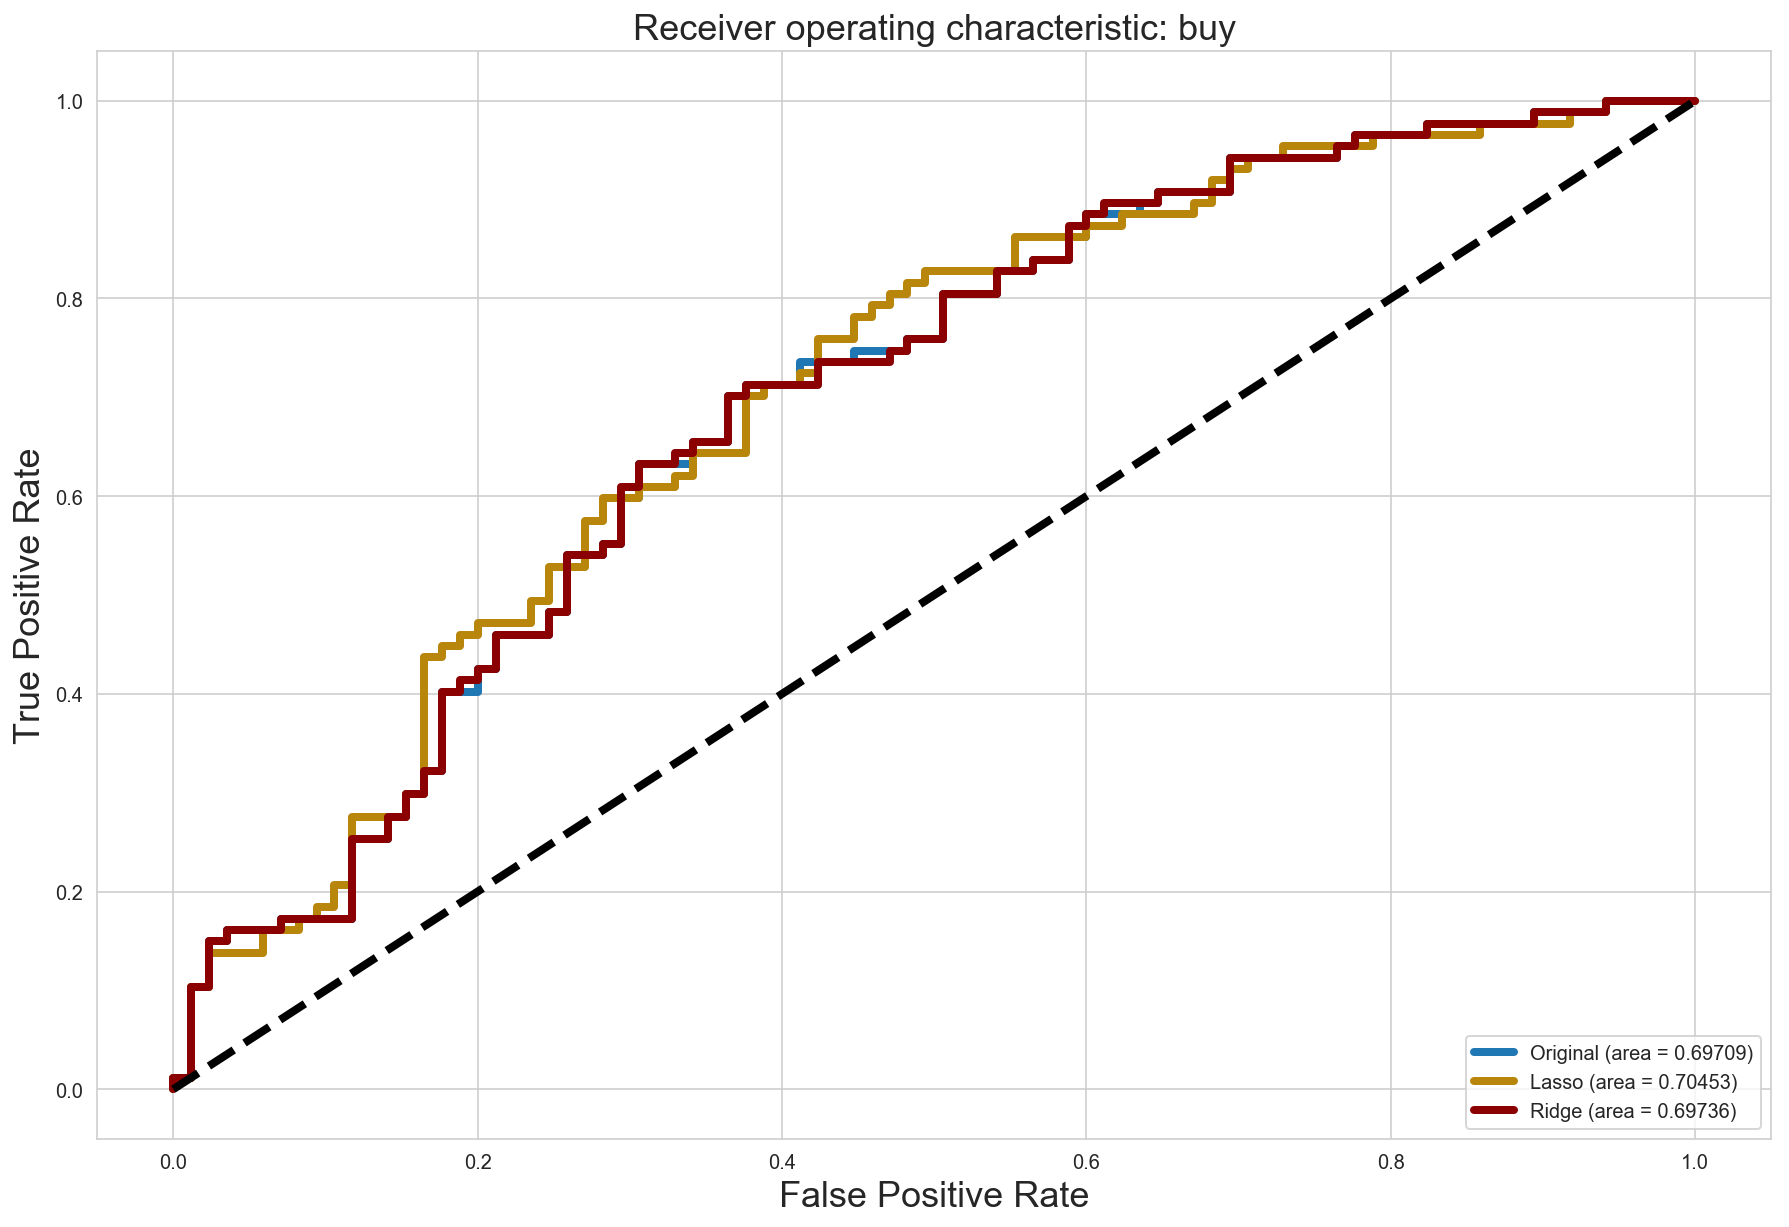

In [141]:
# plotting all logisitc, ridge and lasso together
#just logisitic regression parameters
fpr, tpr, _ = metrics.roc_curve(y_post2010, logreg_y_hat[:,1])
roc_auc = metrics.auc(fpr, tpr)

#Ridge parameters
fpr_ridge, tpr_ridge, _ = metrics.roc_curve(y_post2010, ridge_y_prob[:,1])
roc_auc_ridge = metrics.auc(fpr_ridge, tpr_ridge)

#Lasso parameters
fpr_lasso, tpr_lasso, _ = metrics.roc_curve(y_post2010, lasso_y_prob[:,1])
roc_auc_lasso = metrics.auc(fpr_lasso, tpr_lasso)

#ROC plots with AUC values
plt.figure(figsize = [15,10])

plt.plot(fpr, tpr, label='Original (area = %0.5f)' % roc_auc, linewidth=4)
plt.plot(fpr_lasso, tpr_lasso, label='Lasso (area = %0.5f)' % roc_auc_lasso, 
         linewidth=4, color='darkgoldenrod')
plt.plot(fpr_ridge, tpr_ridge, label='Ridge (area = %0.5f)' % roc_auc_ridge, 
         linewidth=4, color='darkred')

plt.plot([0, 1], [0, 1], 'k--', linewidth = 4)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.title('Receiver operating characteristic: buy', fontsize = 18)
plt.legend(loc = "lower right")
plt.show()

From the graph above, the logisitic regression with lasso regularisation model can achieve an accuracy of 0.7 which is rather accurate. The confusion matrixs (both Lasso and Ridge) are also rather precise. I will trust the model to determine houses to buy as the accuracy is 0.7. However the company may choose to adjust the threshold for the logistic regression model to fine tune the profit margin or improve the model accuracyin the future before putting this model into production.    

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: